In [1]:
import pandas as pd
import numpy as np
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}


In [2]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)
    
    return(predictions)


In [4]:
def polynomial_dataframe(feature, degree):
    # assume that degree >= 1
    # initialize the SFrame:
    
    # and set poly_sframe['power_1'] equal to the passed feature
    poly_sframe = pd.DataFrame(feature)
    poly_sframe.columns = ['power_1']
    # first check if degree > 1
    if degree > 1:
        # then loop over the remaining degrees:
        # range usually starts at 0 and stops at the endpoint-1. We want it to start at 2 and stop at degree
        for power in range(2, degree+1): 
            # first we'll give the column a name:
            name = 'power_' + str(power)
            # then assign poly_sframe[name] to the appropriate power of feature
            poly_sframe[name] = feature**power
            
    return poly_sframe

## Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part.  As we saw, the derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which you should set to `True` when computing the derivative of the constant and `False` otherwise.

In [5]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    
    if(feature_is_constant ==True):
        derivative = (2 * np.dot(errors,feature)) + 2 * l2_penalty * weight
    else:
        derivative = (2 * np.dot(errors, feature))
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    
    return derivative

Test your feature derivartive run the following:

In [7]:
import pprint 

sales = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)
sales = sales.sort_values(by = ['sqft_living','price'])
sales['constant'] =1
#sales = sales.insert(loc=0, column='constant', value=newclm)

print(sales.head(1))

               id             date     price  bedrooms  bathrooms  \
19452  3980300371  20140926T000000  142000.0       0.0        0.0   

       sqft_living  sqft_lot  floors  waterfront  view    ...     sqft_above  \
19452        290.0     20875     1.0           0     0    ...            290   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
19452              0      1963             0    98024  47.5308 -121.888   

       sqft_living15  sqft_lot15  constant  
19452         1620.0     22850.0         1  

[1 rows x 22 columns]


In [9]:
example_features = sales[['constant','sqft_living']]
example_output = sales['price']
my_weights = np.array([1., 10.])

test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

print(errors.shape)
print(example_features.shape)
print(my_weights.shape)

(21613,)
(21613, 2)
(2,)


In [18]:
print( (2 * np.dot(errors, example_features)).shape)

print(example_features.head(2))

(2,)
       constant  sqft_living
19452         1        290.0
15381         1        370.0


In [21]:
print (feature_derivative_ridge(errors, example_features['constant'], my_weights[1], 1, False))

print (feature_derivative_ridge(errors, example_features, my_weights, 1, False))


-22446749330.0
[ -2.24467493e+10  -5.65541668e+13]


To test your feature derivartive run the following:

In [27]:
# next two lines should print the same values
print (feature_derivative_ridge(errors, example_features['sqft_living'], my_weights[1], 1, False))
print (np.sum(errors*example_features['sqft_living'])*2+20.)

# next two lines should print the same values
print (feature_derivative_ridge(errors, example_features['constant'], my_weights[0], 1, True))
print (np.sum(errors)*2.)

print ('sum of squared error = ', np.sum(errors)*2.)

-5.6554166816e+13
-56554166815950.0
-22446749328.0
-22446749330.0
sum of squared error =  -22446749330.0


# Gradient Descent
Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of increase and therefore the negative gradient is the direction of decrease and we're trying to minimize a cost function.

The amount by which we move in the negative gradient direction is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a maximum number of iterations and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

In [35]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    print ('Starting gradient descent with l2_penalty = ' + str(l2_penalty))
    
    weights = np.array(initial_weights) # make sure it's a numpy array
    iteration = 0 # iteration counter
    print_frequency = 1  # for adjusting frequency of debugging output
    
    #while not reached maximum number of iterations:
    while iteration < max_iterations:
        
        iteration += 1  # increment iteration counter
        ### === code section for adjusting frequency of debugging output. ===
        if iteration == 10:
            print_frequency = 10
        if iteration == 100:
            print_frequency = 100
        if iteration%print_frequency==0:
            print('Iteration = ' + str(iteration))
        ### === end code section ===
        
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights) 
        # compute the errors as predictions - output
        errors = predictions - output
        # from time to time, print the value of the cost function
        if iteration%print_frequency==0:
            print ('Cost function = ', str(np.dot(errors,errors) + l2_penalty*(np.dot(weights,weights) - weights[0]**2)))
        
        #for i in xrange(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
        derivative = feature_derivative_ridge(errors, feature_matrix, weights, l2_penalty, True)
        weights -= step_size * derivative
            # subtract the step size times the derivative from the current weight
            
    print ('Done with gradient descent at iteration ', iteration)
    print ('Learned weights = ', str(weights))
    return weights

# Visualizing effect of L2 penalty

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [60]:
train = pd.read_csv('kc_house_train_data.csv')
test = pd.read_csv('kc_house_test_data.csv')

train['constant'] =1
test['constant']=1

train_example_features = train[['constant','sqft_living']]
test_example_features = test[['constant','sqft_living']]

output_train_example = train['price']
output_test_texample = test['price']

In this part, we will only use 'sqft_living' to predict 'price'. Use the get_numpy_data function to get a Numpy versions of your data with only this feature, for both the train_data and the test_data.

Let's set the parameters for our optimization:

In [61]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000


First, let's consider no regularization. Set the l2_penalty to 0.0 and run your ridge regression algorithm to learn the weights of your model. Call your weights:

simple_weights_0_penalty

we'll use them later.

In [62]:
simple_weights_0_penalty = ridge_regression_gradient_descent(train_example_features, 
                                                       output_train_example, 
                                                       initial_weights, 
                                                       step_size, 
                                                       0, 
                                                       max_iterations)


Starting gradient descent with l2_penalty = 0
Iteration = 1
Cost function =  7.43305185234e+15
Iteration = 2
Cost function =  5.39426721353e+15
Iteration = 3
Cost function =  4.02323773629e+15
Iteration = 4
Cost function =  3.1012561833e+15
Iteration = 5
Cost function =  2.4812476436e+15
Iteration = 6
Cost function =  2.0643080768e+15
Iteration = 7
Cost function =  1.78392709616e+15
Iteration = 8
Cost function =  1.59537820185e+15
Iteration = 9
Cost function =  1.4685839897e+15
Iteration = 10
Cost function =  1.38331819009e+15
Iteration = 20
Cost function =  1.21156213902e+15
Iteration = 30
Cost function =  1.20831376121e+15
Iteration = 40
Cost function =  1.20825232478e+15
Iteration = 50
Cost function =  1.20825116214e+15
Iteration = 60
Cost function =  1.20825113944e+15
Iteration = 70
Cost function =  1.2082511383e+15
Iteration = 80
Cost function =  1.20825113757e+15
Iteration = 90
Cost function =  1.20825113685e+15
Iteration = 100
Cost function =  1.20825113613e+15
Iteration = 200
C

In [63]:
simple_weights_high_penalty = ridge_regression_gradient_descent(train_example_features, 
                                                       output_train_example, 
                                                       initial_weights, 
                                                       step_size, 
                                                       1e11, 
                                                       max_iterations)

Starting gradient descent with l2_penalty = 100000000000.0
Iteration = 1
Cost function =  7.43305185234e+15
Iteration = 2
Cost function =  5.61830389891e+15
Iteration = 3
Cost function =  4.92061332784e+15
Iteration = 4
Cost function =  4.65238205635e+15
Iteration = 5
Cost function =  4.54925894962e+15
Iteration = 6
Cost function =  4.50961265457e+15
Iteration = 7
Cost function =  4.49437039712e+15
Iteration = 8
Cost function =  4.4885104179e+15
Iteration = 9
Cost function =  4.48625751221e+15
Iteration = 10
Cost function =  4.48539136804e+15
Iteration = 20
Cost function =  4.48485042808e+15
Iteration = 30
Cost function =  4.48485039003e+15
Iteration = 40
Cost function =  4.48485039004e+15
Iteration = 50
Cost function =  4.48485039005e+15
Iteration = 60
Cost function =  4.48485039005e+15
Iteration = 70
Cost function =  4.48485039005e+15
Iteration = 80
Cost function =  4.48485039005e+15
Iteration = 90
Cost function =  4.48485039005e+15
Iteration = 100
Cost function =  4.48485039005e+15


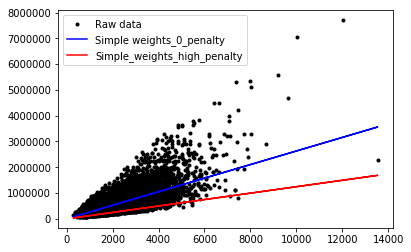

In [64]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
%matplotlib inline
plt.plot(train_example_features['sqft_living'],output_train_example,'k.')
plt.plot(train_example_features['sqft_living'],predict_output(train_example_features, simple_weights_0_penalty),
         'b-')
plt.plot(train_example_features['sqft_living'],predict_output(train_example_features, simple_weights_high_penalty),
         'r-')

plt.legend( ["Raw data", "Simple weights_0_penalty", "Simple_weights_high_penalty"])

Compute the RSS on the TEST data for the following three sets of weights:

The initial weights (all zeros)

The weights learned with no regularization

The weights learned with high regularization

Which weights perform best?

In [45]:
def Residual_sum_square(output, predicts):
    return ((output-predicts)**2).sum()


In [65]:
# RSS of no_regularization
print("RSS of zero regulation: ", Residual_sum_square(
    output_test_texample, 
    predict_output(test_example_features, simple_weights_0_penalty) ))

RSS of zero regulation:  275723632153607.75


In [69]:
# RSS of high_regularization
print("RSS of high regulation: ", Residual_sum_square(
    output_test_texample, 
    predict_output(test_example_features, simple_weights_high_penalty) )/(1e14))

RSS of high regulation:  6.946543095785416


In [68]:
# RSS of initial weights of zeros

print("RSS of zero weights: ", ((output_test_texample)**2).sum()/(1e15))

RSS of zero weights:  1.784273286136298


# Running a multiple regression with L2 penalty

Let us now consider a model with 2 features: ['sqft_living', 'sqft_living15'].

First, create Numpy versions of your training and test data with these two features.

First, create Numpy versions of your training and test data with these two features.

In [70]:
train_feature_matrix = train[['constant','sqft_living','sqft_living15']]
test_feature_matrix = test[['constant','sqft_living','sqft_living15']]
output_train = train['price']
output_test = test['price']

We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [71]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

First, let's consider no regularization. Set the l2_penalty to 0.0 and run your ridge regression algorithm to learn the weights of your model. Call your weights:

multiple_weights_0_penalty

In [72]:
multiple_weights_0_penalty = ridge_regression_gradient_descent(train_feature_matrix, 
                                                       output_train, 
                                                       initial_weights, 
                                                       step_size, 
                                                       0, 
                                                       max_iterations)

Starting gradient descent with l2_penalty = 0
Iteration = 1
Cost function =  7.43305185234e+15
Iteration = 2
Cost function =  4.05675233205e+15
Iteration = 3
Cost function =  2.52956511453e+15
Iteration = 4
Cost function =  1.8385566943e+15
Iteration = 5
Cost function =  1.52567557515e+15
Iteration = 6
Cost function =  1.38378949857e+15
Iteration = 7
Cost function =  1.31923260615e+15
Iteration = 8
Cost function =  1.28964887188e+15
Iteration = 9
Cost function =  1.27588472391e+15
Iteration = 10
Cost function =  1.2692788074e+15
Iteration = 20
Cost function =  1.25781238602e+15
Iteration = 30
Cost function =  1.25195457086e+15
Iteration = 40
Cost function =  1.24675542266e+15
Iteration = 50
Cost function =  1.24213950817e+15
Iteration = 60
Cost function =  1.23804140048e+15
Iteration = 70
Cost function =  1.23440301274e+15
Iteration = 80
Cost function =  1.2311727742e+15
Iteration = 90
Cost function =  1.22830489923e+15
Iteration = 100
Cost function =  1.22575873839e+15
Iteration = 200

Next, let's consider high regularization. Set the l2_penalty to 1e11 and run your ridge regression algorithm to learn the weights of your model. Call your weights:

multiple_weights_high_penalty

In [73]:
multiple_weights_high_penalty = ridge_regression_gradient_descent(train_feature_matrix, 
                                                       output_train, 
                                                       initial_weights, 
                                                       step_size, 
                                                       1e11, 
                                                       max_iterations)

Starting gradient descent with l2_penalty = 100000000000.0
Iteration = 1
Cost function =  7.43305185234e+15
Iteration = 2
Cost function =  4.46048979092e+15
Iteration = 3
Cost function =  3.79667450459e+15
Iteration = 4
Cost function =  3.64831960209e+15
Iteration = 5
Cost function =  3.61509121357e+15
Iteration = 6
Cost function =  3.60760289463e+15
Iteration = 7
Cost function =  3.60588651809e+15
Iteration = 8
Cost function =  3.60547511535e+15
Iteration = 9
Cost function =  3.60536545395e+15
Iteration = 10
Cost function =  3.60532973391e+15
Iteration = 20
Cost function =  3.60529506655e+15
Iteration = 30
Cost function =  3.60529477466e+15
Iteration = 40
Cost function =  3.60529477179e+15
Iteration = 50
Cost function =  3.60529477176e+15
Iteration = 60
Cost function =  3.60529477176e+15
Iteration = 70
Cost function =  3.60529477176e+15
Iteration = 80
Cost function =  3.60529477176e+15
Iteration = 90
Cost function =  3.60529477176e+15
Iteration = 100
Cost function =  3.60529477176e+15

Compute the RSS on the TEST data for the following three sets of weights:

The initial weights (all zeros)

The weights learned with no regularization

The weights learned with high regularization

Which weights perform best?

In [76]:
# RSS of no_regularization
print("RSS of zero regulation: ", Residual_sum_square(
    output_test, 
    predict_output(test_feature_matrix, multiple_weights_0_penalty) )/1e14)

# RSS of high_regularization
print("RSS of high regulation: ", Residual_sum_square(
    output_test, 
    predict_output(test_feature_matrix, multiple_weights_high_penalty) )/1e14)

# RSS of initial weights of zeros

print("RSS of zero weights: ", ((output_test)**2).sum())

RSS of zero regulation:  2.7406761591857567
RSS of high regulation:  5.004085302367192
RSS of zero weights:  1784273286136298.0


Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.) How far is the prediction from the actual price? Which weights perform best for the 1st house?

In [57]:
predict_zeros_penality = predict_output(test_feature_matrix, multiple_weights_0_penalty)
predict_high_penality = predict_output(test_feature_matrix, multiple_weights_high_penalty)
print("original price: ", output_test[0])
print("price of zeros_peanlity: ", predict_zeros_penality[0])
print("price of zeros_peanlity: ", predict_high_penality[0])



original price:  323000.0
price of zeros_peanlity:  514644.075028
price of zeros_peanlity:  281140.910142


In [58]:
print(output_test[0:10])

0    323000.0
1    530000.0
2    189000.0
3    687500.0
4    240000.0
5    585000.0
6    425000.0
7    699950.0
8    375000.0
9    205425.0
Name: price, dtype: float64


# QUIZ QUESTIONS

What is the value of the coefficient for sqft_living that you learned with no regularization, rounded to 1 decimal place? 

What about the one with high regularization?

What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)?

We make prediction for the first house in the test set using two sets of weights (no regularization vs high regularization).

Which weights make better prediction for that particular house?